In [ ]:
import pandas as pd

true_df = pd.read_csv('/content/True.csv')
fake_df = pd.read_csv('/content/Fake.csv')

# Labels
true_df['label'] = 1
fake_df['label'] = 0

# Concatenate the dataframes(df)
df = pd.concat([true_df, fake_df], axis= 0)

df = df.sample(frac=1).reset_index(drop=True)


In [ ]:
df.head()

,title,text,subject,date,label
0,WATCH HERO Singlehandedly Shut Down Anti-Trump...,The video below is one of the highlights from ...,left-news,"Dec 29, 2017",0
1,UK PM May welcomes Trump's pick for U.S. ambas...,LONDON (Reuters) - The planned appointment of ...,politicsNews,"June 23, 2017",1
2,Florida insurers shares tumble as Hurricane Ir...,"(Reuters) - Shares of Florida home insurers, i...",worldnews,"September 5, 2017",1
3,Snowden Laughs-off CIA Excuse of ‘Mistakenly D...,21st Century Wire says This week s announcemen...,US_News,"May 20, 2016",0
4,OBAMA INCITING A SECOND COLD WAR? 35 Russian D...,Reuters reports:The United States expelled 35 ...,politics,"Dec 29, 2016",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [ ]:
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


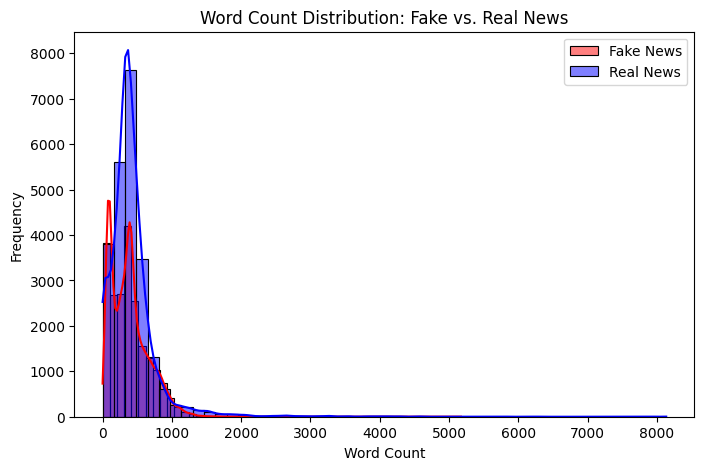

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))

# Separate Fake and Real news
fake_wc = df[df["label"] == 1]["word_count"]
real_wc = df[df["label"] == 0]["word_count"]

plt.figure(figsize=(8, 5))
sns.histplot(fake_wc, bins=50, color="red", label="Fake News", kde=True)
sns.histplot(real_wc, bins=50, color="blue", label="Real News", kde=True)

plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Word Count Distribution: Fake vs. Real News")
plt.legend()
plt.show()


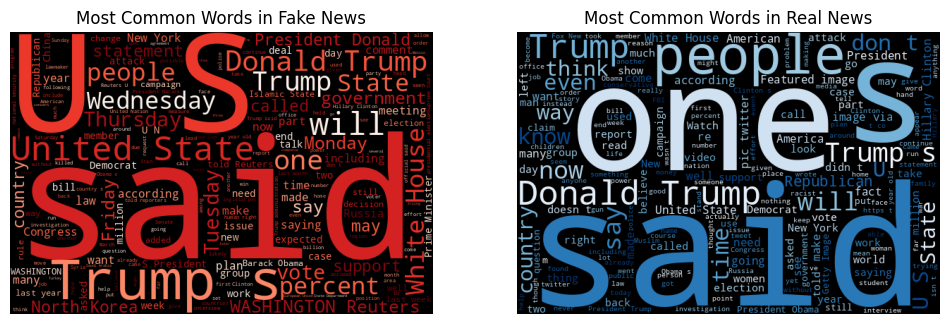

In [ ]:
from wordcloud import WordCloud

# Combine all text from each category
fake_text = " ".join(df[df["label"] == 1]["text"])
real_text = " ".join(df[df["label"] == 0]["text"])

fake_wc = WordCloud(width=600, height=400, background_color="black", colormap="Reds").generate(fake_text)
real_wc = WordCloud(width=600, height=400, background_color="black", colormap="Blues").generate(real_text)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(fake_wc)
plt.axis("off")
plt.title("Most Common Words in Fake News")

plt.subplot(1, 2, 2)
plt.imshow(real_wc)
plt.axis("off")
plt.title("Most Common Words in Real News")

plt.show()


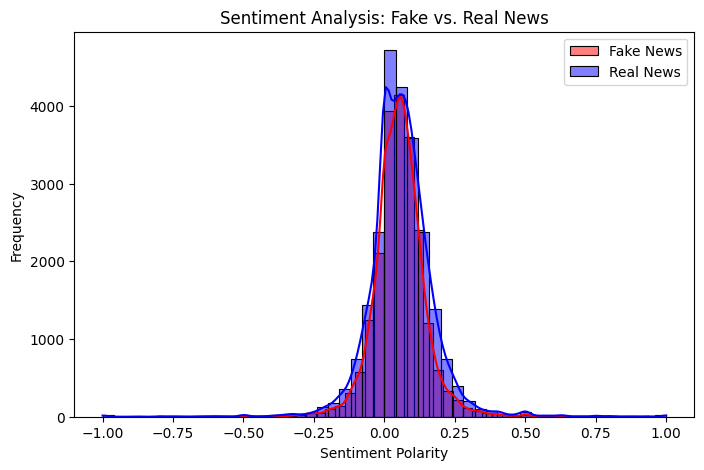

In [ ]:
from textblob import TextBlob

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

df["polarity"] = df["text"].apply(get_polarity)

# Separate polarity for Fake and Real news
fake_polarity = df[df["label"] == 1]["polarity"]
real_polarity = df[df["label"] == 0]["polarity"]

plt.figure(figsize=(8, 5))
sns.histplot(fake_polarity, bins=50, color="red", label="Fake News", kde=True)
sns.histplot(real_polarity, bins=50, color="blue", label="Real News", kde=True)

plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.title("Sentiment Analysis: Fake vs. Real News")
plt.legend()
plt.show()

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

df = df.drop(columns=['title', 'subject', 'date'], errors='ignore')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['cleaned_text'] = df['text'].apply(preprocess_text)

print(df[['text', 'cleaned_text']].head())

                                                text  \
0  The video below is one of the highlights from ...   
1  LONDON (Reuters) - The planned appointment of ...   
2  (Reuters) - Shares of Florida home insurers, i...   
3  21st Century Wire says This week s announcemen...   
4  Reuters reports:The United States expelled 35 ...   

                                        cleaned_text  
0  video one highlight protest last year proteste...  
1  london reuters planned appointment national fo...  
2  reuters share florida home insurer including h...  
3  21st century wire say week announcement cia so...  
4  reuters report united state expelled 35 russia...  


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X = tfidf_vectorizer.fit_transform(df['cleaned_text'])

y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (35918, 5000)
Testing set shape: (8980, 5000)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

print("Naïve Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naïve Bayes Accuracy: 0.9356347438752785
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4677
           1       0.94      0.93      0.93      4303

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9978841870824053
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4677
           1       1.00      1.00      1.00      4303

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
from google.colab import files

# Download trained model
files.download("model.pkl")

# Download vectorizer
files.download("vectorizer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>